# Imports

In [2]:
import sys
from typing import Set
modules: Set[str] = set(sys.modules)
%pip install -q pip --upgrade
if not ('jupyternotify') in modules:
    %pip install -q jupyternotify
import numpy as np
if np.__version__ != "1.2.4":
    %pip install -q numpy==1.2.4
if not ('folium' in modules):
    %pip install -q folium==0.2.1
    modules.add('folium')
if not ('imgaug' in modules):
    %pip install -q imgaug==0.2.6
    modules.add('imgaug')
if not ('tensorflow_text' in modules):
    %pip install -q tensorflow_text==2.9.0
    modules.add('tensorflow_text')
if not ('seaborn' in modules):
    %pip -q install -q seaborn
    modules.add('seaborn')
if not ('tqdm' in modules):
    %pip install -q tqdm
    modules.add('tqdm')
if not ('matplotlib' in modules):
    %pip install -q matplotlib
    modules.add('matplotlib')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# standart liberies:
from typing import List, Optional, Tuple
import datetime
import os
import csv
import random
import statistics
from functools import cache
# NOT-standart liberies:
import tensorflow as tf
import tensorflow_text as tf_text
import pandas as pd
import seaborn as sns
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [4]:
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"tf text version: {tf_text.__version__}")

Python version: 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Tensorflow version: 2.9.1
tf text version: 2.9.0


In [5]:
print('GPU info:/n')
!nvidia-smi

GPU info:/n


'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


# Settings

In [6]:
tf.random.set_seed(0)
random.seed(0)
tf.keras.backend.set_floatx('float16')

In [7]:
device: str
if 'google.colab' in modules:
    device = 'colab'
else:
    device = 'locally'
curr_folder = os.getcwd()

# Hyper-Parameters

In [8]:
set_size: int = 32
batch_size: int = 16
learning_rate: float = 0.001

max_seq_len: int = 1024
num_sets: int = (max_seq_len // set_size) - 1 # Because we dont predict the first set
# number of sets in each sequence

num_blocks: int = 4
d_model: int = 128
dff: int = 256
num_heads: int = 8
dropout_rate: float = 0.1

# Data loading

In [9]:
if device == 'colab':  # If notebook is ran on colab
    from google.colab import drive
    if not os.path.isdir('/drive'):
        drive.mount('/drive')
    df: pd.DataFrame = pd.read_csv('/drive/MyDrive/final_project/wikipedia_articles.csv')
else:  # If notebook is ran on my laptop
    df: pd.DataFrame = pd.read_csv('wiki_data/articles.csv')
print(df.shape)

(30279, 2)


In [10]:
df: pd.Series = df['text']
data_list: List[str] = df.to_list()
DATA_SIZE = len(data_list)
print(f"There are {DATA_SIZE} data points")
string_lengths: List[int] = [len(data_point) for data_point in data_list]
max_string_len = max(string_lengths)
print(f"The length of the longest text IN CHARACTERS is: {max_string_len}")
min_string_len = min(string_lengths)
print(f"The length of the shortest text IN CHARACTERS is: {min_string_len}")

There are 30279 data points
The length of the longest text IN CHARACTERS is: 141803
The length of the shortest text IN CHARACTERS is: 816


## Creating the vocabulary

In [11]:
# %%time
bert_tokenizer_params: dict = dict(lower_case=True)
VOCAB_SIZE: int = 8192  # Always the same for all models

if device == 'colab':  # If notebook is ran on colab
    path = '/drive/MyDrive/final_project/vocab.txt'
else:  # If notebook is ran on my laptop
    path = 'C:/yoni/final_project/model/vocab.txt'


reserved_tokens: List[str] = ["[PAD]", "[UNK]", "[START]", "[END]", "[MASK]"]

if os.path.exists(path):
    with open(path, 'r') as f:
        vocab: List[str] = f.read().split()
else:
    bert_vocab_args: dict = dict(
        # The target vocabulary size
        vocab_size = VOCAB_SIZE,
        # Reserved tokens that must be included in the vocabulary
        reserved_tokens=reserved_tokens,
        # Arguments for `tf_text.BertTokenizer`
        bert_tokenizer_params=bert_tokenizer_params,
        # Arguments for `wordpiece_vocab.wordpiece_tokenizer_learner_lib.learn`
        learn_params={},
    )
    tensor_list: List = [tf.convert_to_tensor(data_point) for data_point in data_list]
    data_set: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tensor_list)
    # I already ran this code and saved the file to C:/yoni/final_project/model/vocab.txt
    vocab: List[str] = tf_text.bert_vocab_from_dataset.bert_vocab_from_dataset(
        data_set,
        **bert_vocab_args,)
    with open('C:/yoni/final_project/model/vocab.txt', 'w') as f:
        for token in vocab:
            f.write(token + ' ')

In [12]:
print(f"the type of the items in vocab: {type(vocab[0])}")
print(f"the first 15 items in vocab: {vocab[:15]}")
print(f" the length of vocab: {len(vocab)}")

the type of the items in vocab: <class 'str'>
the first 15 items in vocab: ['[PAD]', '[UNK]', '[START]', '[END]', '[MASK]', "'", ',', '.', '0', '1', '2', '3', '4', '5', '6']
 the length of vocab: 7882


In [13]:
tensor_vocab: List[tf.Tensor] = [tf.convert_to_tensor(token_key, dtype=tf.string) for token_key in vocab]  # dtype = tf.String
print(f" the type of the items in tensor_vocab is: {type(tensor_vocab[0])}")
print(f" the data type of the tensors in tensor_vocab is: {tensor_vocab[0].dtype}")
vocab_size = len(vocab)

 the type of the items in tensor_vocab is: <class 'tensorflow.python.framework.ops.EagerTensor'>
 the data type of the tensors in tensor_vocab is: <dtype: 'string'>


## Creating the tokenizer

In [14]:
lookup_table = tf.lookup.StaticVocabularyTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=tensor_vocab,
        key_dtype=tf.string,
        values=tf.range(tf.size(vocab, out_type=tf.int64), dtype=tf.int64),
        value_dtype=tf.int64),
    num_oov_buckets=1
)
tokenizer = tf_text.BertTokenizer(lookup_table, **bert_tokenizer_params)

## Tokenizing the data

In [15]:
# START: int = tf.argmax(tf.constant(reserved_tokens) == "[START]")  # The value of the start token
# END: int = tf.argmax(tf.constant(reserved_tokens) == "[END]")  # The value of the end token
# starts = tf.cast(tf.Variable([START]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
# ends = tf.cast(tf.Variable([END]), dtype = tf.int32)  # Tensor of shape [1] and dtype int
starts = tf.constant([2], dtype=tf.int32)
ends = tf.constant([3], dtype=tf.int32)
pad_int: int = int(tf.argmax(tf.constant(reserved_tokens) == "[PAD]"))
pad_ten: tf.TensorSpec(dtype=tf.int32, shape=()) = tf.constant([pad_int], dtype=tf.int32)

In [16]:
def tokenize_string(text: str) -> tf.Tensor:
    """Converts string to tensor"""
    ragged: tf.RaggedTensor = tokenizer.tokenize(text)[0, :]
    eager: tf.Tensor = ragged.to_tensor(default_value=0, shape=[None, 1])  # 0 is the value of the padding token
    sqeezed: tf.Tensor = tf.squeeze(eager, axis=1)
    typed: tf.Tensor = tf.cast(sqeezed, tf.int32)
    edited: tf.Tensor = tf.concat([starts, typed, ends], axis=0)
    return edited

In [18]:
tokenized_data: List[tf.Tensor] = [tokenize_string(data_point) for data_point in data_list] 

# tqdm is a progress bar


KeyboardInterrupt



In [ ]:
print(len(tokenized_data))
print(tokenized_data[0].shape)
print(tokenized_data[0][:10])

30279
(670,)
tf.Tensor([   2 1011 7670   57   18 6423  617   33   61   44], shape=(10,), dtype=int32)


25315
178


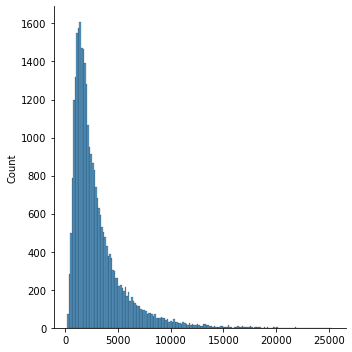

In [ ]:
lengths_tokenized: List[int] = [text.shape[0] for text in tokenized_data]
print(max(lengths_tokenized))
print(min(lengths_tokenized))
sns.displot(lengths_tokenized);

### chunk too long texts

In [ ]:
def chunk_tensor(tensor: tf.Tensor, max_len: int = max_seq_len) -> List[tf.Tensor]:
    """Splits 1d tensor to chunks (1d tensors) of maximum size: max_len"""
    return [tensor[i*max_len:(i+1)*max_len] for i in range(tensor.shape[0] // max_len)]

In [ ]:
chunked_data: List[tf.Tensor] = []
for tensor in tokenized_data:
    chunks = chunk_tensor(tensor, max_seq_len)
    for chunk in chunks:
        chunked_data.append(chunk)
DATA_SIZE: int = len(chunked_data)
print(DATA_SIZE)
print(chunked_data[0].shape)

72513
(1024,)


## Padding

In [ ]:
def pad(tensor: tf.Tensor, pad_int: int) -> tf.Tensor:
    """Pads the tensor to the length of the longest text in the data set"""
    padded: tf.Tensor = tf.pad(tensor=tensor, paddings=[[pad_int, max_seq_len - tensor.shape[0]]], mode='CONSTANT', constant_values=0)
    # 0 is the padding token
    return padded

In [ ]:
padded_data: List[tf.Tensor] = [pad(text, pad_int) for text in chunked_data]
print(padded_data[0])

tf.Tensor([   2    7 3852 ...    7   44 3909], shape=(1024,), dtype=int32)


## Train test val split

In [ ]:
random.shuffle(padded_data)
train_size: int = int(DATA_SIZE * 0.8)
val_test_size: int = int(DATA_SIZE * 0.1)  # Both validation and test get 10% of the data

train_tokenized: List[tf.Tensor] = padded_data[:train_size]
val_tokenized: List[tf.Tensor] = padded_data[train_size:(val_test_size + train_size)]
test_tokenized: List[tf.Tensor] = padded_data[(train_size + val_test_size):]

In [ ]:
def list_to_dataset(tokenized_list: List[tf.Tensor]) -> tf.data.Dataset:
    """Converts a list of tokenized texts after all preprocessing to a tf.data.Dataset"""
    dataset: tf.data.Dataset = tf.data.Dataset.from_tensor_slices(tokenized_list)
    batched: tf.data.Dataset = dataset.batch(batch_size)
    return batched

train_set: tf.data.Dataset = list_to_dataset(train_tokenized)
val_set: tf.data.Dataset = list_to_dataset(val_tokenized)
test_set: tf.data.Dataset = list_to_dataset(test_tokenized)

list_train_set = list(train_set)
list_val_set = list(val_set)
list_test_set = list(test_set)

## Clear memory

In [ ]:
del train_tokenized, test_tokenized, val_tokenized
del padded_data, chunked_data, tokenized_data, data_list, df, lengths_tokenized, 
del string_lengths, lookup_table
del train_set, val_set, test_set

# Model


## Positional encoding

The formula for calculating the positional encoding is as follows:

$${PE_{(pos, 2i)} = \sin(pos / 10000^{2i / d_{model}})} $$
$${PE_{(pos, 2i+1)} = \cos(pos / 10000^{2i / d_{model}})} $$

where $d_{model}$ is the model dimension, $pos$ is the position and $i$ is the index of the embedding.
this is taken from the paper: attention is all you need.

In [ ]:
def create_positional_encoding(max_len: int, d_model: int) -> tf.Tensor:
    """Returns the positional encoding for a given a maximal sequence length and model dimension.
    inputs: max_len: int, d_model: int
    returns: tf.Tensor of shape (1, max_len, d_model) and dtype tf.keras.backend.floatx()
    The 1 is for the batch dimension, the place in the batch dimension does not matter"""

    def get_angles(positions: np.ndarray, timestamps: np.ndarray, d_model: int) -> np.ndarray:
        """Returns the angle in radians for given positions, timestamps and the dimension of the model
        input: positions: np.ndarray of shape (max_len, 1), timestamps: np.ndarray of shape (1, d_model), d_model: int
        output: np.ndarray of shape (max_len, d_model)"""
        if tf.keras.backend.floatx() == "float32":
            angle_rates = 1 / np.power(10000, ((2 * (timestamps//2)) / np.float32(d_model)))
        else:
            angle_rates = 1 / np.power(10000, ((2 * (timestamps//2)) / np.float16(d_model)))

        return positions * angle_rates
    
    angle_rads = get_angles(np.arange(max_len)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)  # (max_len, d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])  # (max_len, d_model)

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])  # (max_len, d_model)

    pos_encode = angle_rads[np.newaxis, ...]  # (1, max_len, d_model)

    return tf.cast(pos_encode, dtype=tf.keras.backend.floatx())

## Masking

Mask all the pad tokens in the batch of sequence. It ensures that the model does not treat padding as the input. The mask indicates where pad value 0 is present: it outputs a 1 at those locations, and a 0 otherwise.

The look-ahead mask is used to mask the future tokens in a sequence. In other words, the mask indicates which entries should not be used.

This means that to predict the third token, only the first and second token will be used. Similarly to predict the fourth token, only the first, second and the third tokens will be used and so on.

In [ ]:
def create_masks(inp: tf.Tensor, tar: tf.Tensor, pad_ten: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
        """Creates all the masks needed for the model
        input: inp: tf.Tensor of shape (batch_size, seq_len), tar: tf.Tensor of shape (batch_size, set_size)
        Returns: Tuple of (padding_mask, look_ahead_mask)
        padding_mask, look_ahead_mask: tf.Tensor of shape (batch_size, 1, 1, seq_len)"""
        
        def create_padding_mask(seq: tf.Tensor) -> tf.Tensor:
                """Returns a padding mask for the given sequence.
                input: seq: tf.Tensor of shape (batch_size, seq_len)
                Returns: tf.Tensor of shape (batch_size, 1, 1, seq_len)"""
                seq = tf.cast(tf.math.equal(seq, pad_ten), tf.keras.backend.floatx())  
                # For every item in the sequence, 1 if it is a padding token, 0 if it is not 

                # add extra dimensions to add the padding
                
                return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)
        
        # Encoder padding mask
        padding_mask: tf.Tensor = create_padding_mask(inp)  # (batch_size, 1, 1, seq_len)

        # Used in the 1st attention block in the decoder.
        # It is used to pad and mask future tokens in the input received by
        # the decoder.
        set_size: int = tar.shape[1]

        @cache
        def create_look_ahead_mask(set_size: int) -> tf.Tensor:
                mask = 1 - tf.linalg.band_part(tf.ones((set_size, set_size)), -1, 0)
                mask = tf.cast(mask, dtype=tf.keras.backend.floatx())
                return mask  # (seq_len, seq_len)

        look_ahead_mask = create_look_ahead_mask(set_size)  # (seq_len, seq_len)
        dec_target_padding_mask = create_padding_mask(tar)  # (batch_size, 1, 1, seq_len)
        look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # (batch_size, 1, 1, seq_len)

        return padding_mask, look_ahead_mask

## Layers and blocks

In [ ]:
class ScaledDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, d_model: int, **kwargs):
        super().__init__(**kwargs)
        self.scale: tf.TensorSpec(shape=(), dtype=tf.keras.backend.floatx())
        # scale = 1 / sqrt(d_model)
        self.scale = tf.math.pow(tf.cast(d_model, tf.keras.backend.floatx()), -0.5)
        self.softmax = tf.keras.layers.Softmax(axis=-1)

    def call(self, q: tf.Tensor, k: tf.Tensor, v: tf.Tensor, mask: Optional[tf.Tensor] = None) -> tf.Tensor:
        """Scaled Dot-Product Attention
        input: 
        q: tf.Tensor of shape (batch_size, seq_len, d_model), 
        k: tf.Tensor of shape (batch_size, seq_len, d_model), 
        v: tf.Tensor of shape (batch_size, seq_len, d_model), 
        mask: Optional[tf.Tensor] of shape (batch_size, 1, 1, seq_len)
        output: tf.Tensor of shape (batch_size, seq_len, d_model)"""
        matmul_qk: tf.Tensor = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

        # Scaled Dot-Product Attention
        scaled_attention_logits: tf.Tensor = matmul_qk * self.scale  # (..., seq_len_q, seq_len_k)
        # matmul_qk / sqrt(d_model)

        # Masking
        if mask is not None:
            # noinspection PyTypeChecker
            if tf.keras.backend.floatx() == 'float16':
                # tf.float16.min is minus infinity
                scaled_attention_logits += (mask * tf.float16.min)  # changed from -1e9 to prevent nan's
            else:
                scaled_attention_logits += (mask * -1e9) 

        # Normalize
        attention_weights = self.softmax(scaled_attention_logits)
        # (..., seq_len_q, seq_len_k)

        # Output
        output = tf.matmul(attention_weights, v)

        return output

In [ ]:
test_sdpa = ScaledDotProductAttention(d_model=128)
q = tf.random.uniform((1, 10, 128), dtype=tf.keras.backend.floatx())
k = tf.random.uniform((1, 10, 128), dtype=tf.keras.backend.floatx())
v = tf.random.uniform((1, 10, 128), dtype=tf.keras.backend.floatx())
mask = tf.random.uniform((1, 1, 1, 10), dtype=tf.keras.backend.floatx())
test_sdpa(q, k, v, mask)

<tf.Tensor: shape=(1, 1, 10, 128), dtype=float16, numpy=
array([[[[0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877],
         [0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877],
         [0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877],
         ...,
         [0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877],
         [0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877],
         [0.669 , 0.2354, 0.877 , ..., 0.3428, 0.0547, 0.8877]]]],
      dtype=float16)>

In [ ]:
class MyMultiHeadAttention(tf.keras.layers.Layer):
    """U can use the built-in tf.keras.layers.multihead_attention but is caused a bug for me"""
    def __init__(self, num_heads: int, d_model: int, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(f"d_model ({d_model}) must be divisible by num_heads ({num_heads})")
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

        self.sdpa = ScaledDotProductAttention(d_model)

    def split_heads(self, x: tf.Tensor, batch_size: int) -> tf.Tensor:
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v_k: tf.Tensor, q: tf.Tensor, mask: tf.Tensor) -> tf.Tensor:
        """inputs:
        v_k: tf.Tensor of shape (batch_size, seq_len, d_model) in self attention keys and values are the same
        q: tf.Tensor of shape (batch_size, seq_len, d_model)
        mask: Optional[tf.Tensor] of shape (batch_size, seq_len)"""
        batch_size = tf.shape(q)[0]

        q: tf.Tensor = self.wq(q)  # (batch_size, seq_len, d_model)
        k: tf.Tensor = self.wk(v_k)  # (batch_size, seq_len, d_model)
        v: tf.Tensor = self.wv(v_k)  # (batch_size, seq_len, d_model)

        q: tf.Tensor = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k: tf.Tensor = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v: tf.Tensor = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape should be (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape should be (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention = self.sdpa(q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
         # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
          # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output

In [ ]:
class PointWiseFeedForwardNetwork(tf.keras.layers.Layer):
    def __init__(self, d_model: int, dff: int, **kwargs): 
        super().__init__(**kwargs)
        self.layer1 = tf.keras.layers.Dense(dff, activation='relu')  # (batch_size, seq_len, dff)
        self.layer2 = tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """Gets tensor of shape (batch_size, seq_len, d_model) and dtype tf.keras.beckend.floatx()
        Returns tensor of shape (batch_size, seq_len, d_model) and dtype tf.keras.beckend.floatx()"""
        x = self.layer1(x)
        x = self.layer2(x)
        return x

In [ ]:
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model: int, num_heads: int, dff: int, drop_out_rate: float, **kwargs):
        super().__init__(**kwargs)

        self.mha = MyMultiHeadAttention(num_heads = num_heads, d_model = d_model)
        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(drop_out_rate)

    def call(self, x: tf.Tensor, training: bool, mask: tf.Tensor) -> tf.Tensor:
        
        attn_output = self.mha(x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout(attn_output, training=training)  # (batch_size, input_seq_len, d_model)
        out1 = self.layer_norm(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout(ffn_output, training=training)  # (batch_size, input_seq_len, d_model)
        out2 = self.layer_norm(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2
        

In [ ]:
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self, d_model: int, num_heads: int, dff: int, rate: float, **kwargs):
        super().__init__(**kwargs)

        self.mha = MyMultiHeadAttention(num_heads = num_heads, d_model = d_model)

        self.ffn = PointWiseFeedForwardNetwork(d_model, dff)

        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor, training):
        # enc_output.shape should be (batch_size, input_seq_len, d_model)

        attn1 = self.mha(x, x, look_ahead_mask)  # (batch_size, set_size, d_model)
        attn1 = self.dropout(attn1, training=training)
        out1 = self.layer_norm(attn1 + x)

        attn2 = self.mha(enc_output, out1, padding_mask)  # (batch_size, set_size, d_model)
        attn2 = self.dropout(attn2, training=training)
        out2 = self.layer_norm(attn2 + out1)  # (batch_size, set_size, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, set_size, d_model)
        ffn_output = self.dropout(ffn_output, training=training)
        out3 = self.layer_norm(ffn_output + out2)  # (batch_size, set_size, d_model)

        return out3
        

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, pos_encoding: tf.Tensor, num_blocks: int, d_model: int, num_heads: int, dff: int, rate=0.1, **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.num_blocks = num_blocks
        self.pos_encoding = pos_encoding

        self.enc_blocks = [EncoderBlock(d_model, num_heads, dff, rate) for _ in range(num_blocks)]
        # the encoder 
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, training, mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(x)[1]

        # adding position encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.keras.backend.floatx()))
        
        x += self.pos_encoding[:, :seq_len, :]  # (batch_size, input_seq_len, d_model)
        x = self.dropout(x, training=training)  # (batch_size, input_seq_len, d_model)

        for i in range(self.num_blocks):
            x = self.enc_blocks[i](x, training, mask)  # (batch_size, input_seq_len, d_model)

        return x  # (batch_size, input_seq_len, d_model)
        

In [ ]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, pos_encoding, num_blocks: int, d_model: int, num_heads: int, dff: int,
                 vocab_size: int, rate: float, **kwargs):
        super().__init__(**kwargs)

        self.d_model = d_model
        self.num_blocks = num_blocks
        self.pos_encoding = pos_encoding

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.dec_layers = [DecoderBlock(d_model, num_heads, dff, rate) for _ in range(num_blocks)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x: tf.Tensor, enc_output: tf.Tensor, training: bool,
             look_ahead_mask: tf.Tensor, padding_mask: tf.Tensor) -> tf.Tensor:

        seq_len = tf.shape(x)[1]

        x = self.embedding(x)  # (batch_size, set_size, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.keras.backend.floatx()))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_blocks):
            x = self.dec_layers[i](x=x, enc_output=enc_output, look_ahead_mask=look_ahead_mask, 
                                   padding_mask=padding_mask, training=training)

        # x.shape should be (batch_size, set_size, d_model)
        return x
        

## The full model

In [ ]:
class SeTransformer(tf.keras.Model):
    """The base architecture of my models in this project."""
    def __init__(self, num_blocks: int, d_model: int, num_heads: int, dff: int,
                 vocab_size: int, max_len: int, rate: float, pad_int: int, **kwargs):
        super().__init__(**kwargs)  # calls tf.keras.Model's __init__ method
        self.pad_int = pad_int
        pos_encoding = create_positional_encoding(max_len, d_model)

        self.encoder = Encoder(pos_encoding, num_blocks, d_model, num_heads, dff, rate)
        self.decoder = Decoder(pos_encoding, num_blocks, d_model, num_heads, dff, vocab_size, rate)

        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model)
        self.dense = tf.keras.layers.Dense(vocab_size)
        self.softmax = tf.keras.layers.Softmax(axis = -1)  # there are {vocab_size} categories in the output

    def call(self, inputs: List[tf.Tensor], training: bool) -> tf.Tensor:
        inp, tar = inputs
        # inp.shape should be (batch_size, max_seq_len) or (1, max_seq_len)
        # tar.shape should be (batch_size, set_size) or (1, set_size)
        padding_mask, look_ahead_mask = create_masks(inp, tar, self.pad_int)
        x = self.embedding(inp)  # (batch_size, max_seq_len, d_model)
        enc_output = self.encoder(x, training, padding_mask)  # (batch_size, max_seq_len, d_model)
        
        # dec_output.shape should be (batch_size, set_size, d_model)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, padding_mask)

        final_output = self.dense(dec_output)
        # final_output.shape should be (batch_size, set_size, vocab_size)
        softmaxed = self.softmax(final_output)
        # softmaxed.shape should be (batch_size, set_size, vocab_size)
        return softmaxed
        

In [ ]:
sample_transformer = SeTransformer(
    num_blocks=2, d_model=32, num_heads=4, dff=128,
    vocab_size=7000,
    max_len=1200, pad_int=0, rate=0.1)

temp_input = tf.random.uniform((1, 1000), dtype=tf.int32, minval=0, maxval=6999)
temp_target = tf.random.uniform((1, 8), dtype=tf.int32, minval=0, maxval=6999)

train_out = sample_transformer([temp_input, temp_target], training=True)

print(train_out.shape)  # (batch_size, set_size, vocab_size)
print(train_out[0][0])

non_train_out = sample_transformer([temp_input, temp_target], training=False)
print(non_train_out.shape)  # (batch_size, set_size, vocab_size)
print(non_train_out[0][0])

del sample_transformer, temp_input, temp_target, train_out, non_train_out

(1, 8, 7000)
tf.Tensor(
[[0.00012004 0.000142   0.0001636  ... 0.0001419  0.00017    0.0001329 ]
 [0.0001242  0.0001345  0.000156   ... 0.0001343  0.0001618  0.0001264 ]
 [0.0001252  0.0001411  0.0001599  ... 0.000142   0.0001662  0.0001293 ]
 ...
 [0.0001234  0.0001405  0.000162   ... 0.0001334  0.0001504  0.0001281 ]
 [0.000125   0.0001382  0.0001541  ... 0.0001297  0.0001563  0.0001316 ]
 [0.0001272  0.0001371  0.0001645  ... 0.0001369  0.0001576  0.000133  ]], shape=(8, 7000), dtype=float16)
(1, 8, 7000)
tf.Tensor(
[[0.0001246 0.0001408 0.0001632 ... 0.0001395 0.000167  0.000132 ]
 [0.0001281 0.000141  0.0001625 ... 0.0001411 0.000167  0.0001312]
 [0.0001271 0.0001391 0.0001616 ... 0.0001415 0.000167  0.0001314]
 ...
 [0.0001261 0.0001366 0.0001599 ... 0.0001361 0.0001624 0.0001323]
 [0.0001279 0.0001377 0.0001607 ... 0.0001379 0.0001599 0.0001339]
 [0.0001292 0.0001377 0.0001639 ... 0.0001403 0.0001599 0.0001335]], shape=(8, 7000), dtype=float16)


# Training the model

## Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, epsilon=tf.keras.backend.epsilon())

NameError: name 'tf' is not defined

## Create the model

In [ ]:
model = SeTransformer(
    num_blocks=num_blocks,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    vocab_size=vocab_size,
    max_len=max_seq_len,
    rate=dropout_rate,
    pad_int=pad_int)

## Training helper functions

### Train step function

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                              tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)])
def train_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
    with tf.GradientTape() as tape:
        pred: tf.Tensor = model([inp, outp], training=True)
        loss_val: tf.Tensor = tf.keras.losses.sparse_categorical_crossentropy(y_true = outp, y_pred = pred)
    grads: tf.RaggedTensor = tape.gradient(loss_val, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_val

### Validate

In [ ]:
def validate(batch) -> float:
    @tf.function(input_signature=[tf.TensorSpec(shape=[batch_size, None], dtype=tf.int32),
                                  tf.TensorSpec(shape=[batch_size, set_size], dtype=tf.int32)])
    def val_step(inp: tf.Tensor, outp: tf.Tensor) -> tf.Tensor:
        pred = model([inp, outp], training=False)
        return tf.keras.losses.sparse_categorical_crossentropy(y_true = outp, y_pred = pred)
    per_generation_loss: List[float] = []
    for i in range(num_sets):
        # The input is of size set_size-TAKE_TO_ACCOUNT
        already_predicted: int = i * (set_size + 1)
        start_from: int = max(0, already_predicted - max_seq_len)
        inp: tf.Tensor = batch[:, start_from:(i + 1) * set_size]
        outp: tf.Tensor = batch[:, (i + 1) * set_size:(i + 2) * set_size]
        loss_val: tf.Tensor = val_step(inp, outp)
        float_loss: float = loss_val.numpy().item()
        per_generation_loss.append(float_loss)
    return statistics.mean(per_generation_loss)

In [ ]:
def check_point(folder_path: str, model: SeTransformer, val_loss: float, train_loss: float):
    """Saves the model at the end of each epoch"""
    path: str = f"{folder_path}/"
    tf.keras.models.save_model(model = model, filepath = path, save_format='tf')
    with open("exmiperments.csv", 'r') as f:
        lines = f.readlines()[:-1]  # All but the last line
    with open("exmiperments.csv", 'w') as f:
        c_writer = csv.writer(f, delimiter=',')
        for line in lines:
            c_writer.writerow(line)
    fields = [date, val_loss, train_loss, set_size, num_blocks, d_model, dff,
              num_heads, learning_rate, max_seq_len, dropout_rate, batch_size]
    with open('experiments.csv', 'a') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(fields)

In [ ]:
date: str = datetime.datetime.now().strftime('%m%d-%H%M')
if device == 'colab':
    folder_path: str = "/drive/MyDrive/final_project/checkpoints/"
else:
    folder_path: str = "C:/yoni/final_project/model/checkpoints/"
check_points_path = f"{folder_path}{date}"
if not os.path.isdir(folder_path):
    os.mkdir(folder_path)
if not os.path.isdir(check_points_path):
    os.mkdir(check_points_path)

In [ ]:
train_loss, val_loss = float('inf'), float('inf')
best_val_loss = float('inf')

In [ ]:
exp_path = "/drive/MyDrive/final_project/experiments.csv" if device == 'colab' else "C:/yoni/final_project/model/experiments.csv"
if not os.pathexist(exp_path)
with open(exp_path, 'a') as f:
    fields = [date, val_loss, train_loss, set_size, num_blocks, d_model, dff,
              num_heads, learning_rate, max_seq_len, dropout_rate, batch_size]
    writer = csv.writer(f)
    writer.writerow(fields)

# The actual training loop!

In [ ]:
EPOCHS: int = 1000  # Train until the cloud disconnects or the model stops improving
per_epoch_train_loss: List[float] = []
per_epoch_val_loss: List[float] = []
for epoch in range(EPOCHS):
    per_batch_train_loss: List[float] = []
    per_batch_val_loss: List[float] = []
    for batch_num, train_batch in tqdm.tqdm(enumerate(list_train_set)):  # tqdm is a progress bar
        per_generation_loss: List[float] = []
        for i in range(num_sets):
            # The input is of size set_size-TAKE_TO_ACCOUNT
            already_predicted: int = i * (set_size + 1)
            start_from: int = max(0, already_predicted - max_seq_len)
            inp: tf.Tensor = train_batch[:, start_from:(i + 1) * set_size]
            outp: tf.Tensor = train_batch[:, (i + 1) * set_size:(i + 2) * set_size]
            loss_val: tf.Tensor = train_step(inp, outp)
            train_loss: float = loss_val.numpy().item()
            per_generation_loss.append(train_loss)
            
        per_batch_train_loss.append(statistics.mean(per_generation_loss))
        if batch_num % 8 == 0:  # 8 is number of training batches/number of val batches
            next_val_batch: tf.Tensor = list_val_set[batch_num // 8]
            val_loss: float = validate(next_val_batch)
            per_batch_val_loss.append(val_loss)
    per_epoch_train_loss.append(statistics.mean(per_batch_train_loss))
    per_epoch_val_loss.append(statistics.mean(per_batch_val_loss))
    if per_epoch_val_loss[-1] > per_epoch_val_loss[-2]:
        check_point(check_points_path, model, per_epoch_val_loss[-1], per_epoch_train_loss[-1])
        print("Validation loss increased. Stopped training")
        %notify("Validation loss increased. Stopped training")
        break

In [ ]:
def plot_loss(loss: List[float], title: str):
    plt.plot(loss)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

plot_loss(per_epoch_train_loss, "Training Loss")
plot_loss(per_epoch_val_loss, "Validation Loss")

In [ ]:
test_loss = statistics.mean([validate(test_batch) for test_batch in list_test_set])
print(f"Test loss: {test_loss}")